In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [17]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                   labels=rates)) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    #aloss2 = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                    labels=tf.nn.sigmoid(targetQs)))
    return actions_logits, aloss, dloss, aloss2

In [18]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [20]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [21]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [23]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [25]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:1.3813 dloss:0.7022 aloss2:0.6927 exploreP:0.9985
Episode:1 meanR:19.5000 R:24.0000 rate:0.0480 aloss:1.3819 dloss:0.7009 aloss2:0.6940 exploreP:0.9961
Episode:2 meanR:25.3333 R:37.0000 rate:0.0740 aloss:1.3799 dloss:0.6903 aloss2:0.7007 exploreP:0.9925
Episode:3 meanR:23.5000 R:18.0000 rate:0.0360 aloss:1.3816 dloss:0.6786 aloss2:0.7078 exploreP:0.9907
Episode:4 meanR:23.6000 R:24.0000 rate:0.0480 aloss:1.3810 dloss:0.6704 aloss2:0.7135 exploreP:0.9884
Episode:5 meanR:24.6667 R:30.0000 rate:0.0600 aloss:1.3812 dloss:0.6673 aloss2:0.7154 exploreP:0.9855
Episode:6 meanR:22.5714 R:10.0000 rate:0.0200 aloss:1.3791 dloss:0.6618 aloss2:0.7191 exploreP:0.9845
Episode:7 meanR:22.3750 R:21.0000 rate:0.0420 aloss:1.3768 dloss:0.6569 aloss2:0.7221 exploreP:0.9824
Episode:8 meanR:23.3333 R:31.0000 rate:0.0620 aloss:1.3801 dloss:0.6414 aloss2:0.7328 exploreP:0.9794
Episode:9 meanR:23.5000 R:25.0000 rate:0.0500 aloss:1.3765 dloss:0.6416 aloss2:0.7

Episode:80 meanR:27.5679 R:26.0000 rate:0.0520 aloss:1.3725 dloss:0.4018 aloss2:1.4187 exploreP:0.8019
Episode:81 meanR:27.7195 R:40.0000 rate:0.0800 aloss:1.3757 dloss:0.3955 aloss2:1.4392 exploreP:0.7987
Episode:82 meanR:27.5542 R:14.0000 rate:0.0280 aloss:1.3865 dloss:0.3971 aloss2:1.4526 exploreP:0.7976
Episode:83 meanR:27.6310 R:34.0000 rate:0.0680 aloss:1.3745 dloss:0.3615 aloss2:1.4531 exploreP:0.7949
Episode:84 meanR:28.0706 R:65.0000 rate:0.1300 aloss:1.3699 dloss:0.3832 aloss2:1.4514 exploreP:0.7899
Episode:85 meanR:28.0581 R:27.0000 rate:0.0540 aloss:1.3785 dloss:0.3818 aloss2:1.4517 exploreP:0.7877
Episode:86 meanR:28.1034 R:32.0000 rate:0.0640 aloss:1.3785 dloss:0.3780 aloss2:1.4843 exploreP:0.7853
Episode:87 meanR:29.5341 R:154.0000 rate:0.3080 aloss:1.3804 dloss:0.3878 aloss2:1.4812 exploreP:0.7734
Episode:88 meanR:29.6854 R:43.0000 rate:0.0860 aloss:1.3881 dloss:0.3813 aloss2:1.4724 exploreP:0.7701
Episode:89 meanR:29.5667 R:19.0000 rate:0.0380 aloss:1.3704 dloss:0.3722

Episode:159 meanR:77.2800 R:47.0000 rate:0.0940 aloss:1.3907 dloss:0.4904 aloss2:1.4069 exploreP:0.4029
Episode:160 meanR:77.4800 R:48.0000 rate:0.0960 aloss:1.3964 dloss:0.4021 aloss2:1.3979 exploreP:0.4010
Episode:161 meanR:79.8500 R:279.0000 rate:0.5580 aloss:1.3978 dloss:0.4311 aloss2:1.3961 exploreP:0.3903
Episode:162 meanR:84.2200 R:458.0000 rate:0.9160 aloss:1.3971 dloss:0.4411 aloss2:1.3907 exploreP:0.3733
Episode:163 meanR:84.7000 R:96.0000 rate:0.1920 aloss:1.3954 dloss:0.4837 aloss2:1.3773 exploreP:0.3698
Episode:164 meanR:85.9100 R:255.0000 rate:0.5100 aloss:1.4011 dloss:0.4779 aloss2:1.3482 exploreP:0.3607
Episode:165 meanR:88.1800 R:238.0000 rate:0.4760 aloss:1.4079 dloss:0.4812 aloss2:1.3159 exploreP:0.3525
Episode:166 meanR:90.6100 R:276.0000 rate:0.5520 aloss:1.4014 dloss:0.4689 aloss2:1.3156 exploreP:0.3432
Episode:167 meanR:94.0600 R:370.0000 rate:0.7400 aloss:1.4070 dloss:0.4670 aloss2:1.3097 exploreP:0.3311
Episode:168 meanR:95.9300 R:223.0000 rate:0.4460 aloss:1.4

Episode:237 meanR:177.7200 R:191.0000 rate:0.3820 aloss:1.4091 dloss:0.5194 aloss2:1.1778 exploreP:0.1060
Episode:238 meanR:178.3800 R:140.0000 rate:0.2800 aloss:1.4111 dloss:0.5069 aloss2:1.1753 exploreP:0.1047
Episode:239 meanR:177.9600 R:161.0000 rate:0.3220 aloss:1.4046 dloss:0.5279 aloss2:1.1778 exploreP:0.1031
Episode:240 meanR:179.6100 R:296.0000 rate:0.5920 aloss:1.4060 dloss:0.5353 aloss2:1.1502 exploreP:0.1004
Episode:241 meanR:181.0900 R:162.0000 rate:0.3240 aloss:1.4039 dloss:0.5128 aloss2:1.1597 exploreP:0.0990
Episode:242 meanR:182.6100 R:262.0000 rate:0.5240 aloss:1.4023 dloss:0.5147 aloss2:1.1574 exploreP:0.0967
Episode:243 meanR:184.0200 R:158.0000 rate:0.3160 aloss:1.3971 dloss:0.5176 aloss2:1.1625 exploreP:0.0953
Episode:244 meanR:183.5300 R:179.0000 rate:0.3580 aloss:1.4009 dloss:0.5112 aloss2:1.1740 exploreP:0.0938
Episode:245 meanR:183.1200 R:171.0000 rate:0.3420 aloss:1.3950 dloss:0.5244 aloss2:1.1725 exploreP:0.0924
Episode:246 meanR:180.8200 R:145.0000 rate:0.2

Episode:315 meanR:275.8600 R:276.0000 rate:0.5520 aloss:1.3379 dloss:0.6658 aloss2:0.8603 exploreP:0.0188
Episode:316 meanR:279.2300 R:500.0000 rate:1.0000 aloss:1.3515 dloss:0.6492 aloss2:0.8594 exploreP:0.0183
Episode:317 meanR:280.5400 R:306.0000 rate:0.6120 aloss:1.3498 dloss:0.6458 aloss2:0.8454 exploreP:0.0181
Episode:318 meanR:283.7300 R:500.0000 rate:1.0000 aloss:1.3390 dloss:0.6601 aloss2:0.8324 exploreP:0.0177
Episode:319 meanR:287.4200 R:500.0000 rate:1.0000 aloss:1.3435 dloss:0.6459 aloss2:0.8376 exploreP:0.0173
Episode:320 meanR:288.7100 R:243.0000 rate:0.4860 aloss:1.3400 dloss:0.6523 aloss2:0.8406 exploreP:0.0171
Episode:321 meanR:290.5700 R:345.0000 rate:0.6900 aloss:1.3385 dloss:0.6615 aloss2:0.8371 exploreP:0.0169
Episode:322 meanR:293.7100 R:500.0000 rate:1.0000 aloss:1.3288 dloss:0.6705 aloss2:0.8190 exploreP:0.0166
Episode:323 meanR:297.0700 R:487.0000 rate:0.9740 aloss:1.3329 dloss:0.6586 aloss2:0.8074 exploreP:0.0162
Episode:324 meanR:300.5800 R:500.0000 rate:1.0

Episode:393 meanR:437.7800 R:500.0000 rate:1.0000 aloss:1.2285 dloss:0.5867 aloss2:0.6173 exploreP:0.0103
Episode:394 meanR:437.7800 R:500.0000 rate:1.0000 aloss:1.2087 dloss:0.5798 aloss2:0.6107 exploreP:0.0103
Episode:395 meanR:436.4400 R:366.0000 rate:0.7320 aloss:1.2089 dloss:0.5711 aloss2:0.6105 exploreP:0.0102
Episode:396 meanR:436.4400 R:500.0000 rate:1.0000 aloss:1.1997 dloss:0.5606 aloss2:0.6087 exploreP:0.0102
Episode:397 meanR:438.7200 R:500.0000 rate:1.0000 aloss:1.2157 dloss:0.5487 aloss2:0.6114 exploreP:0.0102
Episode:398 meanR:440.2600 R:500.0000 rate:1.0000 aloss:1.2031 dloss:0.5464 aloss2:0.6070 exploreP:0.0102
Episode:399 meanR:443.1300 R:500.0000 rate:1.0000 aloss:1.2001 dloss:0.5480 aloss2:0.6065 exploreP:0.0102
Episode:400 meanR:443.8000 R:500.0000 rate:1.0000 aloss:1.2058 dloss:0.5446 aloss2:0.6084 exploreP:0.0102
Episode:401 meanR:443.8700 R:500.0000 rate:1.0000 aloss:1.2000 dloss:0.5368 aloss2:0.6065 exploreP:0.0102
Episode:402 meanR:444.0400 R:500.0000 rate:1.0

Episode:471 meanR:452.1100 R:500.0000 rate:1.0000 aloss:1.0360 dloss:0.1953 aloss2:0.8828 exploreP:0.0100
Episode:472 meanR:452.1100 R:500.0000 rate:1.0000 aloss:1.0301 dloss:0.1682 aloss2:0.9005 exploreP:0.0100
Episode:473 meanR:452.1100 R:500.0000 rate:1.0000 aloss:1.0279 dloss:0.1818 aloss2:0.9081 exploreP:0.0100
Episode:474 meanR:452.1100 R:500.0000 rate:1.0000 aloss:1.0292 dloss:0.1812 aloss2:0.9039 exploreP:0.0100
Episode:475 meanR:453.7200 R:500.0000 rate:1.0000 aloss:1.0284 dloss:0.1791 aloss2:0.9088 exploreP:0.0100
Episode:476 meanR:453.7200 R:500.0000 rate:1.0000 aloss:1.0256 dloss:0.1965 aloss2:0.9059 exploreP:0.0100
Episode:477 meanR:453.7200 R:500.0000 rate:1.0000 aloss:1.0279 dloss:0.1626 aloss2:0.9210 exploreP:0.0100
Episode:478 meanR:453.7200 R:500.0000 rate:1.0000 aloss:1.0252 dloss:0.1429 aloss2:0.9470 exploreP:0.0100
Episode:479 meanR:456.6400 R:500.0000 rate:1.0000 aloss:1.0263 dloss:0.1357 aloss2:0.9674 exploreP:0.0100
Episode:480 meanR:456.6400 R:500.0000 rate:1.0

Episode:549 meanR:470.9900 R:500.0000 rate:1.0000 aloss:0.9554 dloss:0.0039 aloss2:1.9552 exploreP:0.0100
Episode:550 meanR:472.3000 R:500.0000 rate:1.0000 aloss:0.9531 dloss:0.0055 aloss2:1.9932 exploreP:0.0100
Episode:551 meanR:471.3600 R:406.0000 rate:0.8120 aloss:0.9536 dloss:0.0057 aloss2:1.9905 exploreP:0.0100
Episode:552 meanR:473.4600 R:500.0000 rate:1.0000 aloss:0.9517 dloss:0.0060 aloss2:1.9817 exploreP:0.0100
Episode:553 meanR:475.0300 R:500.0000 rate:1.0000 aloss:0.9480 dloss:0.0047 aloss2:2.0013 exploreP:0.0100
Episode:554 meanR:474.1200 R:409.0000 rate:0.8180 aloss:0.9494 dloss:0.0060 aloss2:2.0030 exploreP:0.0100
Episode:555 meanR:476.6400 R:500.0000 rate:1.0000 aloss:0.9495 dloss:0.0081 aloss2:1.9750 exploreP:0.0100
Episode:556 meanR:476.6400 R:500.0000 rate:1.0000 aloss:0.9446 dloss:0.0070 aloss2:1.9631 exploreP:0.0100
Episode:557 meanR:476.6400 R:500.0000 rate:1.0000 aloss:0.9464 dloss:0.0059 aloss2:1.9699 exploreP:0.0100
Episode:558 meanR:474.4500 R:281.0000 rate:0.5

Episode:627 meanR:469.7000 R:231.0000 rate:0.4620 aloss:0.8879 dloss:0.0071 aloss2:2.1788 exploreP:0.0100
Episode:628 meanR:467.0100 R:231.0000 rate:0.4620 aloss:0.8826 dloss:0.0051 aloss2:2.1445 exploreP:0.0100
Episode:629 meanR:467.9700 R:500.0000 rate:1.0000 aloss:0.8792 dloss:0.0061 aloss2:2.1434 exploreP:0.0100
Episode:630 meanR:467.9700 R:500.0000 rate:1.0000 aloss:0.8775 dloss:0.0033 aloss2:2.1890 exploreP:0.0100
Episode:631 meanR:467.9700 R:500.0000 rate:1.0000 aloss:0.8820 dloss:0.0069 aloss2:2.1780 exploreP:0.0100
Episode:632 meanR:469.9500 R:500.0000 rate:1.0000 aloss:0.8796 dloss:0.0061 aloss2:2.1812 exploreP:0.0100
Episode:633 meanR:467.3800 R:243.0000 rate:0.4860 aloss:0.8803 dloss:0.0062 aloss2:2.1602 exploreP:0.0100
Episode:634 meanR:467.3800 R:500.0000 rate:1.0000 aloss:0.8769 dloss:0.0040 aloss2:2.1712 exploreP:0.0100
Episode:635 meanR:464.5900 R:221.0000 rate:0.4420 aloss:0.8789 dloss:0.0050 aloss2:2.1870 exploreP:0.0100
Episode:636 meanR:464.5900 R:500.0000 rate:1.0

Episode:705 meanR:450.4100 R:500.0000 rate:1.0000 aloss:0.8366 dloss:0.0021 aloss2:2.8698 exploreP:0.0100
Episode:706 meanR:450.4100 R:500.0000 rate:1.0000 aloss:0.8378 dloss:0.0008 aloss2:2.9241 exploreP:0.0100
Episode:707 meanR:450.4100 R:500.0000 rate:1.0000 aloss:0.8374 dloss:0.0024 aloss2:2.9205 exploreP:0.0100
Episode:708 meanR:447.9700 R:256.0000 rate:0.5120 aloss:0.8381 dloss:0.0012 aloss2:2.9013 exploreP:0.0100
Episode:709 meanR:445.9100 R:294.0000 rate:0.5880 aloss:0.8365 dloss:0.0004 aloss2:2.9283 exploreP:0.0100
Episode:710 meanR:445.9100 R:500.0000 rate:1.0000 aloss:0.8356 dloss:0.0013 aloss2:2.9624 exploreP:0.0100
Episode:711 meanR:445.9100 R:500.0000 rate:1.0000 aloss:0.8364 dloss:0.0021 aloss2:2.9473 exploreP:0.0100
Episode:712 meanR:448.7000 R:500.0000 rate:1.0000 aloss:0.8354 dloss:0.0011 aloss2:2.9280 exploreP:0.0100
Episode:713 meanR:448.7000 R:500.0000 rate:1.0000 aloss:0.8367 dloss:0.0014 aloss2:2.9485 exploreP:0.0100
Episode:714 meanR:448.7000 R:500.0000 rate:1.0

Episode:783 meanR:461.4500 R:500.0000 rate:1.0000 aloss:0.8228 dloss:0.0016 aloss2:3.0692 exploreP:0.0100
Episode:784 meanR:463.0000 R:500.0000 rate:1.0000 aloss:0.8222 dloss:0.0020 aloss2:3.0569 exploreP:0.0100
Episode:785 meanR:463.0000 R:500.0000 rate:1.0000 aloss:0.8232 dloss:0.0022 aloss2:3.0744 exploreP:0.0100
Episode:786 meanR:463.0000 R:500.0000 rate:1.0000 aloss:0.8228 dloss:0.0020 aloss2:3.0533 exploreP:0.0100
Episode:787 meanR:459.1800 R:118.0000 rate:0.2360 aloss:0.8233 dloss:0.0020 aloss2:3.0596 exploreP:0.0100
Episode:788 meanR:459.1800 R:500.0000 rate:1.0000 aloss:0.8231 dloss:0.0034 aloss2:3.0067 exploreP:0.0100
Episode:789 meanR:459.1800 R:500.0000 rate:1.0000 aloss:0.8223 dloss:0.0020 aloss2:3.0639 exploreP:0.0100
Episode:790 meanR:459.1800 R:500.0000 rate:1.0000 aloss:0.8235 dloss:0.0012 aloss2:3.1114 exploreP:0.0100
Episode:791 meanR:459.1800 R:500.0000 rate:1.0000 aloss:0.8219 dloss:0.0021 aloss2:3.0885 exploreP:0.0100
Episode:792 meanR:459.1800 R:500.0000 rate:1.0

Episode:861 meanR:477.6600 R:500.0000 rate:1.0000 aloss:0.8058 dloss:0.0062 aloss2:2.1903 exploreP:0.0100
Episode:862 meanR:477.6600 R:500.0000 rate:1.0000 aloss:0.8057 dloss:0.0042 aloss2:2.2217 exploreP:0.0100
Episode:863 meanR:477.6600 R:500.0000 rate:1.0000 aloss:0.8051 dloss:0.0036 aloss2:2.2379 exploreP:0.0100
Episode:864 meanR:474.2300 R:157.0000 rate:0.3140 aloss:0.8041 dloss:0.0043 aloss2:2.2578 exploreP:0.0100
Episode:865 meanR:474.2300 R:500.0000 rate:1.0000 aloss:0.8058 dloss:0.0068 aloss2:2.2020 exploreP:0.0100
Episode:866 meanR:474.2300 R:500.0000 rate:1.0000 aloss:0.8056 dloss:0.0043 aloss2:2.2235 exploreP:0.0100
Episode:867 meanR:473.0800 R:385.0000 rate:0.7700 aloss:0.8053 dloss:0.0034 aloss2:2.2651 exploreP:0.0100
Episode:868 meanR:469.7500 R:167.0000 rate:0.3340 aloss:0.8055 dloss:0.0060 aloss2:2.2417 exploreP:0.0100
Episode:869 meanR:469.7500 R:500.0000 rate:1.0000 aloss:0.8047 dloss:0.0067 aloss2:2.2116 exploreP:0.0100
Episode:870 meanR:472.4400 R:500.0000 rate:1.0

Episode:939 meanR:455.0000 R:500.0000 rate:1.0000 aloss:0.8018 dloss:0.0054 aloss2:2.3188 exploreP:0.0100
Episode:940 meanR:455.0000 R:500.0000 rate:1.0000 aloss:0.8057 dloss:0.0057 aloss2:2.3155 exploreP:0.0100
Episode:941 meanR:455.0000 R:500.0000 rate:1.0000 aloss:0.8038 dloss:0.0064 aloss2:2.2861 exploreP:0.0100
Episode:942 meanR:453.3400 R:334.0000 rate:0.6680 aloss:0.8002 dloss:0.0053 aloss2:2.2807 exploreP:0.0100
Episode:943 meanR:453.2300 R:371.0000 rate:0.7420 aloss:0.8085 dloss:0.0087 aloss2:2.2728 exploreP:0.0100
Episode:944 meanR:451.6500 R:342.0000 rate:0.6840 aloss:0.8000 dloss:0.0045 aloss2:2.2747 exploreP:0.0100
Episode:945 meanR:451.6500 R:500.0000 rate:1.0000 aloss:0.8027 dloss:0.0075 aloss2:2.2925 exploreP:0.0100
Episode:946 meanR:450.7800 R:413.0000 rate:0.8260 aloss:0.8021 dloss:0.0049 aloss2:2.2679 exploreP:0.0100
Episode:947 meanR:448.9900 R:321.0000 rate:0.6420 aloss:0.8103 dloss:0.0065 aloss2:2.2920 exploreP:0.0100
Episode:948 meanR:445.1900 R:120.0000 rate:0.2

Episode:1017 meanR:480.4800 R:500.0000 rate:1.0000 aloss:0.7885 dloss:0.0050 aloss2:2.4024 exploreP:0.0100
Episode:1018 meanR:479.5300 R:405.0000 rate:0.8100 aloss:0.7880 dloss:0.0066 aloss2:2.4137 exploreP:0.0100
Episode:1019 meanR:479.5300 R:500.0000 rate:1.0000 aloss:0.7917 dloss:0.0082 aloss2:2.3543 exploreP:0.0100
Episode:1020 meanR:479.5300 R:500.0000 rate:1.0000 aloss:0.7886 dloss:0.0081 aloss2:2.3660 exploreP:0.0100
Episode:1021 meanR:479.5300 R:500.0000 rate:1.0000 aloss:0.7897 dloss:0.0073 aloss2:2.3482 exploreP:0.0100
Episode:1022 meanR:479.5300 R:500.0000 rate:1.0000 aloss:0.7871 dloss:0.0056 aloss2:2.3472 exploreP:0.0100
Episode:1023 meanR:480.5000 R:500.0000 rate:1.0000 aloss:0.7938 dloss:0.0090 aloss2:2.3437 exploreP:0.0100
Episode:1024 meanR:480.5000 R:500.0000 rate:1.0000 aloss:0.7891 dloss:0.0052 aloss2:2.3804 exploreP:0.0100
Episode:1025 meanR:480.5000 R:500.0000 rate:1.0000 aloss:0.7872 dloss:0.0060 aloss2:2.3712 exploreP:0.0100
Episode:1026 meanR:480.5000 R:500.000

Episode:1094 meanR:479.6100 R:500.0000 rate:1.0000 aloss:0.7789 dloss:0.0092 aloss2:2.4631 exploreP:0.0100
Episode:1095 meanR:479.6100 R:500.0000 rate:1.0000 aloss:0.7750 dloss:0.0032 aloss2:2.4218 exploreP:0.0100
Episode:1096 meanR:479.6100 R:500.0000 rate:1.0000 aloss:0.7751 dloss:0.0050 aloss2:2.4321 exploreP:0.0100
Episode:1097 meanR:479.6100 R:500.0000 rate:1.0000 aloss:0.7745 dloss:0.0042 aloss2:2.4286 exploreP:0.0100
Episode:1098 meanR:480.1100 R:408.0000 rate:0.8160 aloss:0.7731 dloss:0.0035 aloss2:2.4649 exploreP:0.0100
Episode:1099 meanR:480.1100 R:500.0000 rate:1.0000 aloss:0.7720 dloss:0.0021 aloss2:2.5220 exploreP:0.0100
Episode:1100 meanR:480.1100 R:500.0000 rate:1.0000 aloss:0.7727 dloss:0.0022 aloss2:2.5237 exploreP:0.0100
Episode:1101 meanR:480.1100 R:500.0000 rate:1.0000 aloss:0.7746 dloss:0.0065 aloss2:2.4697 exploreP:0.0100
Episode:1102 meanR:480.1100 R:500.0000 rate:1.0000 aloss:0.7723 dloss:0.0018 aloss2:2.5158 exploreP:0.0100
Episode:1103 meanR:478.2700 R:316.000

Episode:1171 meanR:479.0100 R:500.0000 rate:1.0000 aloss:0.7734 dloss:0.0084 aloss2:2.3157 exploreP:0.0100
Episode:1172 meanR:479.0100 R:500.0000 rate:1.0000 aloss:0.7694 dloss:0.0063 aloss2:2.3160 exploreP:0.0100
Episode:1173 meanR:479.0100 R:500.0000 rate:1.0000 aloss:0.7690 dloss:0.0058 aloss2:2.3109 exploreP:0.0100
Episode:1174 meanR:477.8400 R:383.0000 rate:0.7660 aloss:0.7690 dloss:0.0063 aloss2:2.3162 exploreP:0.0100
Episode:1175 meanR:479.0300 R:500.0000 rate:1.0000 aloss:0.7693 dloss:0.0065 aloss2:2.2737 exploreP:0.0100
Episode:1176 meanR:479.0300 R:500.0000 rate:1.0000 aloss:0.7678 dloss:0.0067 aloss2:2.2880 exploreP:0.0100
Episode:1177 meanR:479.0300 R:500.0000 rate:1.0000 aloss:0.7693 dloss:0.0050 aloss2:2.3285 exploreP:0.0100
Episode:1178 meanR:479.0300 R:500.0000 rate:1.0000 aloss:0.7680 dloss:0.0044 aloss2:2.3595 exploreP:0.0100
Episode:1179 meanR:479.6500 R:431.0000 rate:0.8620 aloss:0.7805 dloss:0.0090 aloss2:2.2877 exploreP:0.0100
Episode:1180 meanR:481.3400 R:500.000

Episode:1248 meanR:485.0500 R:500.0000 rate:1.0000 aloss:0.7647 dloss:0.0042 aloss2:2.3180 exploreP:0.0100
Episode:1249 meanR:486.6000 R:500.0000 rate:1.0000 aloss:0.7662 dloss:0.0046 aloss2:2.3477 exploreP:0.0100
Episode:1250 meanR:486.6000 R:500.0000 rate:1.0000 aloss:0.7652 dloss:0.0047 aloss2:2.3395 exploreP:0.0100
Episode:1251 meanR:486.6000 R:500.0000 rate:1.0000 aloss:0.7683 dloss:0.0063 aloss2:2.3030 exploreP:0.0100
Episode:1252 meanR:487.2200 R:500.0000 rate:1.0000 aloss:0.7640 dloss:0.0048 aloss2:2.3608 exploreP:0.0100
Episode:1253 meanR:487.1400 R:492.0000 rate:0.9840 aloss:0.7664 dloss:0.0062 aloss2:2.3345 exploreP:0.0100
Episode:1254 meanR:487.1400 R:500.0000 rate:1.0000 aloss:0.7645 dloss:0.0081 aloss2:2.2944 exploreP:0.0100
Episode:1255 meanR:487.1400 R:500.0000 rate:1.0000 aloss:0.7645 dloss:0.0055 aloss2:2.3179 exploreP:0.0100
Episode:1256 meanR:487.1400 R:500.0000 rate:1.0000 aloss:0.7656 dloss:0.0053 aloss2:2.3329 exploreP:0.0100
Episode:1257 meanR:487.1400 R:500.000

Episode:1325 meanR:482.1700 R:500.0000 rate:1.0000 aloss:0.7606 dloss:0.0087 aloss2:2.3775 exploreP:0.0100
Episode:1326 meanR:482.1700 R:500.0000 rate:1.0000 aloss:0.7617 dloss:0.0058 aloss2:2.3809 exploreP:0.0100
Episode:1327 meanR:482.1700 R:500.0000 rate:1.0000 aloss:0.7590 dloss:0.0048 aloss2:2.4542 exploreP:0.0100
Episode:1328 meanR:482.1700 R:500.0000 rate:1.0000 aloss:0.7592 dloss:0.0050 aloss2:2.4526 exploreP:0.0100
Episode:1329 meanR:482.1700 R:500.0000 rate:1.0000 aloss:0.7597 dloss:0.0049 aloss2:2.4841 exploreP:0.0100
Episode:1330 meanR:482.1700 R:500.0000 rate:1.0000 aloss:0.7612 dloss:0.0062 aloss2:2.4720 exploreP:0.0100
Episode:1331 meanR:483.6800 R:500.0000 rate:1.0000 aloss:0.7623 dloss:0.0058 aloss2:2.4696 exploreP:0.0100
Episode:1332 meanR:482.5800 R:390.0000 rate:0.7800 aloss:0.7630 dloss:0.0053 aloss2:2.4894 exploreP:0.0100
Episode:1333 meanR:482.5800 R:500.0000 rate:1.0000 aloss:0.7603 dloss:0.0050 aloss2:2.4966 exploreP:0.0100
Episode:1334 meanR:482.5800 R:500.000

Episode:1402 meanR:486.3400 R:500.0000 rate:1.0000 aloss:0.7600 dloss:0.0046 aloss2:2.6284 exploreP:0.0100
Episode:1403 meanR:486.3400 R:500.0000 rate:1.0000 aloss:0.7585 dloss:0.0042 aloss2:2.6489 exploreP:0.0100
Episode:1404 meanR:487.6800 R:500.0000 rate:1.0000 aloss:0.7589 dloss:0.0063 aloss2:2.6351 exploreP:0.0100
Episode:1405 meanR:487.9100 R:500.0000 rate:1.0000 aloss:0.7588 dloss:0.0054 aloss2:2.6583 exploreP:0.0100
Episode:1406 meanR:487.9100 R:500.0000 rate:1.0000 aloss:0.7593 dloss:0.0051 aloss2:2.6318 exploreP:0.0100
Episode:1407 meanR:486.7600 R:385.0000 rate:0.7700 aloss:0.7602 dloss:0.0049 aloss2:2.6555 exploreP:0.0100
Episode:1408 meanR:488.1400 R:500.0000 rate:1.0000 aloss:0.7588 dloss:0.0054 aloss2:2.6614 exploreP:0.0100
Episode:1409 meanR:488.1400 R:500.0000 rate:1.0000 aloss:0.7601 dloss:0.0044 aloss2:2.6735 exploreP:0.0100
Episode:1410 meanR:488.1400 R:500.0000 rate:1.0000 aloss:0.7610 dloss:0.0059 aloss2:2.6811 exploreP:0.0100
Episode:1411 meanR:488.1400 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

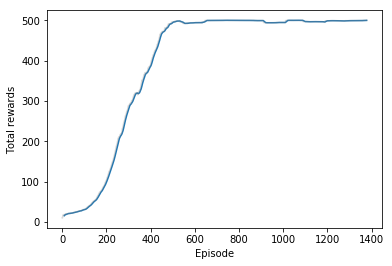

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

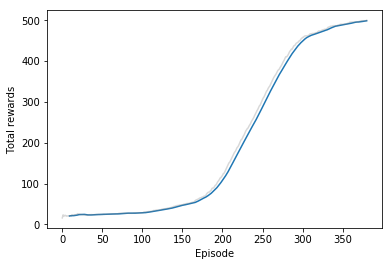

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

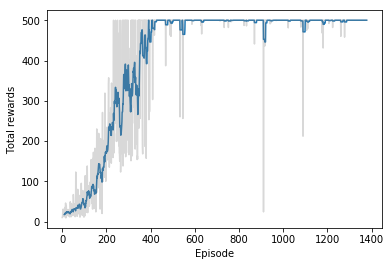

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

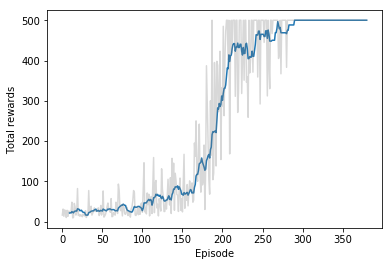

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.